In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


In [2]:
#importing data
dataset= pd.read_csv('diabetes.csv',header=None)
print("Data Shape:",dataset.shape)
print(dataset.head())
dataset=dataset.iloc[1:]


Data Shape: (769, 9)
             0        1              2              3        4     5  \
0  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI   
1            6      148             72             35        0  33.6   
2            1       85             66             29        0  26.6   
3            8      183             64              0        0  23.3   
4            1       89             66             23       94  28.1   

                          6    7        8  
0  DiabetesPedigreeFunction  Age  Outcome  
1                     0.627   50        1  
2                     0.351   31        0  
3                     0.672   32        1  
4                     0.167   21        0  


In [3]:
#splitting the data
train_dataset=dataset.sample(frac=0.75)
test_dataset=dataset.drop(train_dataset.index)
x_train,y_train=train_dataset.iloc[:,:-1],train_dataset.iloc[:,-1]
x_test,y_test=test_dataset.iloc[:,:-1],test_dataset.iloc[:,-1]

x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

In [4]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
    self.std = tf.Variable(tf.math.reduce_std(x, axis=0))

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

#data normalization
norm_x = Normalize(x_train)
x_train_norm, x_test_norm = norm_x.norm(x_train), norm_x.norm(x_test)

In [5]:
#regression model
class LogisticRegression(tf.Module):

  def __init__(self):
    self.built = False

  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weight vector and bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

log_reg = LogisticRegression()

In [6]:
y_pred = log_reg(x_train_norm[:5], train=False)
y_pred.numpy()

array([0.88897663, 0.8594714 , 0.335239  , 0.72331125, 0.40026128],
      dtype=float32)

In [7]:
def log_loss(y_pred, y):
  # Compute the log loss
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)


def predict_class(y_pred, thresh=0.5):
  # Return a tensor with : 1. if y_pred_i > 0.5 and 0. ow/
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between y_pred and y
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val

In [8]:
#model training

batch_size = 75
dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
dataset = dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)


# Set training parameters
epochs = 300
learning_rate = 0.03
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Format training loop
for epoch in range(epochs):
  batch_losses, batch_accs = [], []
  for x_batch, y_batch in dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level model performance 
    batch_losses.append(batch_loss)
    batch_accs.append(batch_acc)
  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses), tf.reduce_mean(batch_accs)
  y_pred_test = log_reg(x_test_norm)
  test_loss, test_acc = log_loss(y_pred_test, y_test), accuracy(y_pred_test, y_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

Epoch: 0, Training log loss: 0.758
Epoch: 20, Training log loss: 0.532
Epoch: 40, Training log loss: 0.487
Epoch: 60, Training log loss: 0.475
Epoch: 80, Training log loss: 0.471
Epoch: 100, Training log loss: 0.466
Epoch: 120, Training log loss: 0.469
Epoch: 140, Training log loss: 0.466
Epoch: 160, Training log loss: 0.473
Epoch: 180, Training log loss: 0.469
Epoch: 200, Training log loss: 0.466
Epoch: 220, Training log loss: 0.466
Epoch: 240, Training log loss: 0.467
Epoch: 260, Training log loss: 0.466
Epoch: 280, Training log loss: 0.464


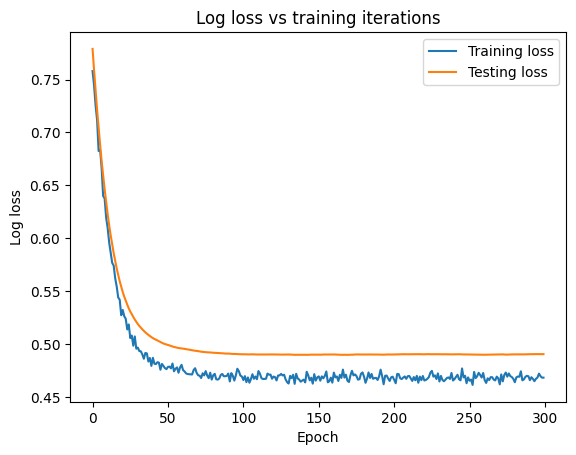

In [9]:
#performance evaluation    
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

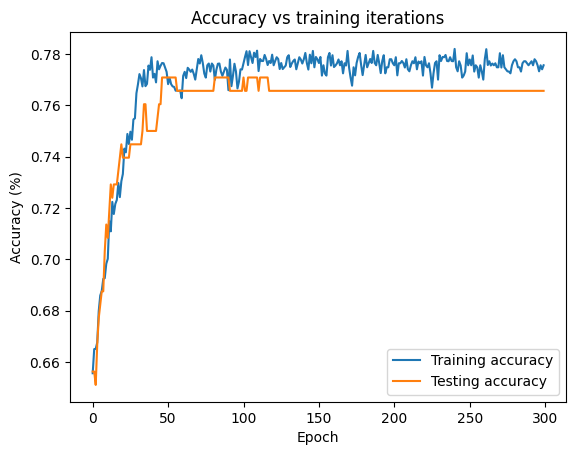

In [10]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");

In [11]:
print(f"Final training log loss: {train_losses[-1]:.3f}")
print(f"Final Testing Log Loss: {test_losses[-1]:.3f}")

print(f"Final training accuracy: {train_accs[-1]:.3f}")
print(f"Final testing accuracy: {test_accs[-1]:.3f}")

Final training log loss: 0.468
Final Testing Log Loss: 0.491
Final training accuracy: 0.776
Final testing accuracy: 0.766
